# Visualization in Python - Case Study

There are many python packages for visualization. We'll focus on capabilities available through pandas, and to a lesser extent, matplotlib. There is great documentation on all of this.
The case study is to analyze the flow of bicycles out of stations in the Pronto trip data.
In this section, we'll discuss:
- the structure of a matplotlib plot
- different plot idioms
- doing multiple plots

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# The following ensures that the plots are in the notebook
%matplotlib inline
# We'll also use capabilities in numpy
import numpy as np

Analysis questions
- Which stations have the biggest difference between in-flow and out-flow of bikes?
- Where can we localize the movement of bicycles between stations that are in close proximity?

## Preparing Data For Plotting

In [2]:
df = pd.read_csv("2015_trip_data.csv")
df.head()

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear
0,431,10/13/2014 10:31,10/13/2014 10:48,SEA00298,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Male,1960
1,432,10/13/2014 10:32,10/13/2014 10:48,SEA00195,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Male,1970
2,433,10/13/2014 10:33,10/13/2014 10:48,SEA00486,883.831,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Female,1988
3,434,10/13/2014 10:34,10/13/2014 10:48,SEA00333,865.937,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Female,1977
4,435,10/13/2014 10:34,10/13/2014 10:49,SEA00202,923.923,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Male,1971


Now let's consider the flow of bicycles from and to stations.

In [3]:
from_counts = pd.value_counts(df.from_station_id)
to_counts = pd.value_counts(df.to_station_id)

## Simple Plots for Series

Let's address the question "Which stations have the biggest difference between the in-flow and out-flow of bicycles?"

What kind of objects are returned from pd.value_counts? Are these plottable? How do we figure this out?

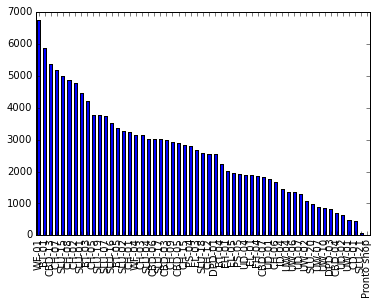

In [4]:
from_counts.plot.bar()

But this plot doesn't tell us about the *difference* between "from" and "to" counts. We want to subtract to_counts from from_counts. Will this difference be plottable?

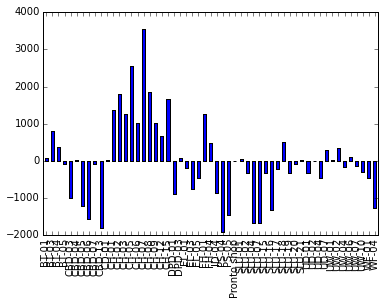

In [5]:
(from_counts-to_counts).plot.bar()

Some issues:
- Bogus value 'Pronto shop'
- Difficult to read the labels on the x-axis
- The x and y axis aren't labelled
- Lost information about "from" and "to"

## Writing a Data Cleansing Function

We want to get rid of the row 'Pronto shop' in both from_counts and to_counts.

In [6]:
# Selecting a row
from_counts[from_counts.index == 'Pronto shop']

Pronto shop    1
Name: from_station_id, dtype: int64

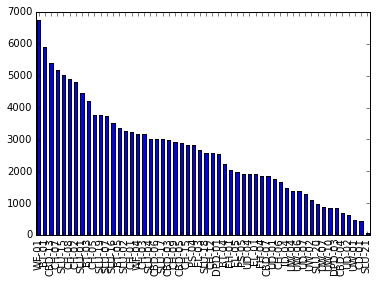

In [7]:
# Deleting a row
new_from_counts = from_counts[from_counts.index != 'Pronto shop']
new_from_counts.plot.bar()

In [8]:
def clean_rows(df, indexes):
    """
    Removes from df all rows with the specified indexes
    :param pd.DataFrame or pd.Series df:
    :param list-of-str indexes
    :return pd.DataFrame or pd.Series:
    """
    for idx in indexes:
        df = df[df.index != idx]
    return df

Does clean_rows need to return df to effect the change in df?

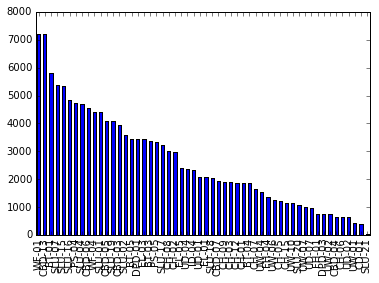

In [9]:
to_counts = clean_rows(to_counts, ['Pronto shop'])
to_counts.plot.bar()

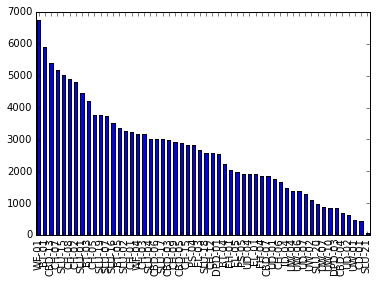

In [10]:
from_counts = clean_rows(from_counts, ['Pronto shop'])
from_counts.plot.bar()

## Getting More Control Over Plots

*Let's take a more detailed approach to plotting so we can better control what gets rendered.*

In this section, we show how to control various elements of plots to produce a desired visualization. We'll use the package matplotlib, a python package that is modelled after MATLAB style plotting.

Make a dataframe out of the count data.

In [11]:
df_counts = pd.DataFrame({'From': from_counts.sort_index(), 'To': to_counts.sort_index()})

Need to align the counts by the station. Do we do this?

In [12]:
df_counts.head()

,From,To
BT-01,5885,5800
BT-03,4199,3386
BT-04,2221,1856
BT-05,3368,3459
CBD-03,2974,3959


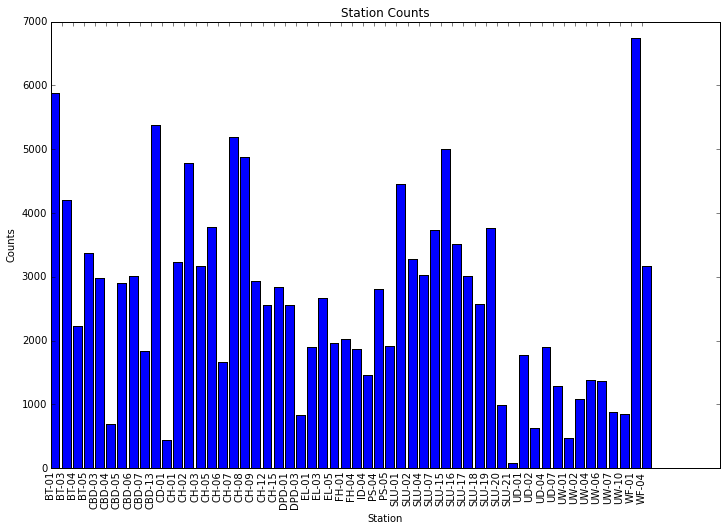

In [13]:
"""
Basic bar chart using matplotlib
"""
import numpy as np
import matplotlib.pyplot as plt


n_groups = len(df_counts.index)
index = np.arange(n_groups)  # The "raw" x-axis of the bar plot

fig = plt.figure(figsize=(12, 8))  # Controls global properties of the bar plot
rects1 = plt.bar(index, df_counts.From)
plt.xlabel('Station')
plt.ylabel('Counts')
plt.xticks(index, df_counts.index)  # Convert "raw" x-axis into labels
_, labels = plt.xticks()  # Get the new labels of the plot
plt.setp(labels, rotation=90)  # Rotate labels to make them readable
plt.title('Station Counts')
plt.show()

To compare 'from' and 'to', we want:
- bars of different colors
- a legend

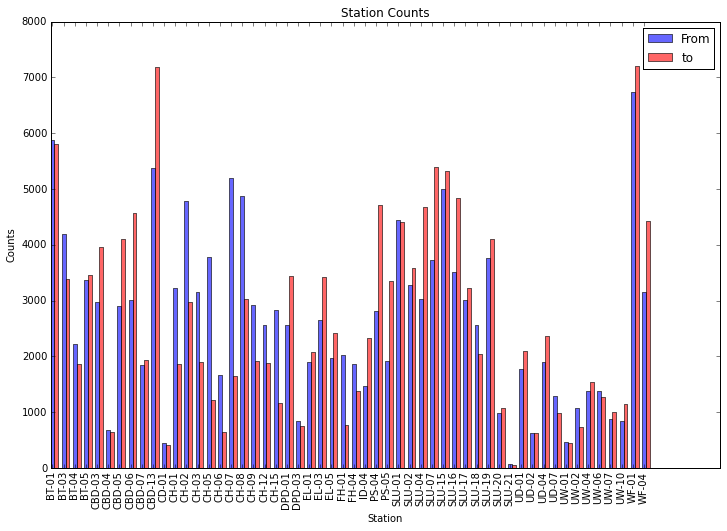

In [14]:
"""
Plotting two variables as a bar chart
"""
import numpy as np
import matplotlib.pyplot as plt


n_groups = len(df_counts.index)
index = np.arange(n_groups)  # The "raw" x-axis of the bar plot
fig = plt.figure(figsize=(12, 8))  # Controls global properties of the bar plot

#VVVV Changed to do two plots
bar_width = 0.35  # Width of the bars
opacity = 0.6  # How transparent the bars are
rects1 = plt.bar(index, df_counts.From, bar_width,
                 alpha=opacity,
                 color='b',
                 label='From')
rects2 = plt.bar(index + bar_width, df_counts.To, bar_width,
                 alpha=opacity,
                 color='r',
                 label='to')
plt.xticks(index + bar_width / 2, df_counts.index)
_, labels = plt.xticks()  # Get the new labels of the plot
plt.setp(labels, rotation=90)  # Rotate labels to make them readable
plt.legend()
#^^^^ Changed to do two plots

plt.xlabel('Station')
plt.ylabel('Counts')
plt.title('Station Counts')
plt.show()

## Including Error Bars in a Bar Chart

To make decisions about the truck trips required to adjust bikes at stations, we need to know the variations by day.

Want a bar plot with average daily "to" and "from" with their standard deviations.

### Data Preparation

Need to:
- Create a date column for 'from' and 'to'
- Compute counts by date
- Compute the mean and standard deviation of the counts by date

(Assumes that a station has at least one rental every day.)

Let's start with the values for starttime. What type are these?

In [15]:
print (df.starttime[0])
print (type(df.starttime[0]))

10/13/2014 10:31
<type 'str'>


Question: How do we extract the day from a string?

YOU DON'T!!! You convert it to a datetime object.

In [16]:
this_datetime = pd.to_datetime(df.starttime[0])
print this_datetime

2014-10-13 10:31:00


In [17]:
start_day = [pd.to_datetime(x).dayofyear for x in df.starttime]
stop_day = [pd.to_datetime(x).dayofyear for x in df.stoptime]

In [18]:
df['startday'] = start_day  # Creates a new column named 'startday'
df['stopday'] = stop_day

In [19]:
df.head()

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear,startday,stopday
0,431,10/13/2014 10:31,10/13/2014 10:48,SEA00298,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Male,1960,286,286
1,432,10/13/2014 10:32,10/13/2014 10:48,SEA00195,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Male,1970,286,286
2,433,10/13/2014 10:33,10/13/2014 10:48,SEA00486,883.831,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Female,1988,286,286
3,434,10/13/2014 10:34,10/13/2014 10:48,SEA00333,865.937,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Female,1977,286,286
4,435,10/13/2014 10:34,10/13/2014 10:49,SEA00202,923.923,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Male,1971,286,286


In [20]:
groupby_day_from = df.groupby(['from_station_id', 'startday']).size()
groupby_day_from.head()

from_station_id  startday
BT-01            1           14
                 2            8
                 3            4
                 4            1
                 5            3
dtype: int64

Now we need to compute the average value and its standard deviation across the days for each station.
The groupby produced a MultiIndex. So, further operations on the result must take this into account.

In [21]:
h_index = groupby_day_from.index
h_index.levshape  # Size of the components of the MultiIndex

(55, 365)

In [22]:
from_means = groupby_day_from.groupby(level=[0]).mean()  # Computes the mean of counts by day
from_stds = groupby_day_from.groupby(level=[0]).std()   # Computes the standard deviation


In [23]:
groupby_day_to = df.groupby(['to_station_id', 'startday']).size()
to_means = groupby_day_to.groupby(level=[0]).mean()  # Computes the mean of counts by day
to_stds = groupby_day_to.groupby(level=[0]).std()   # Computes the standard deviation

In [24]:
df_day_counts = pd.DataFrame({'from_mean': from_means, 'from_std': from_stds, 'to_mean': to_means, 'to_std': to_stds})
df_day_counts.head()

,from_mean,from_std,to_mean,to_std
from_station_id,,,,
BT-01,16.167582,11.459929,16.022099,11.649049
BT-03,11.599448,5.791607,9.276712,4.882986
BT-04,6.256338,3.510949,5.411079,2.896377
BT-05,9.329640,5.128833,9.635097,5.111931
CBD-03,8.238227,5.803139,10.876374,6.287737


### Plotting with Error Bars

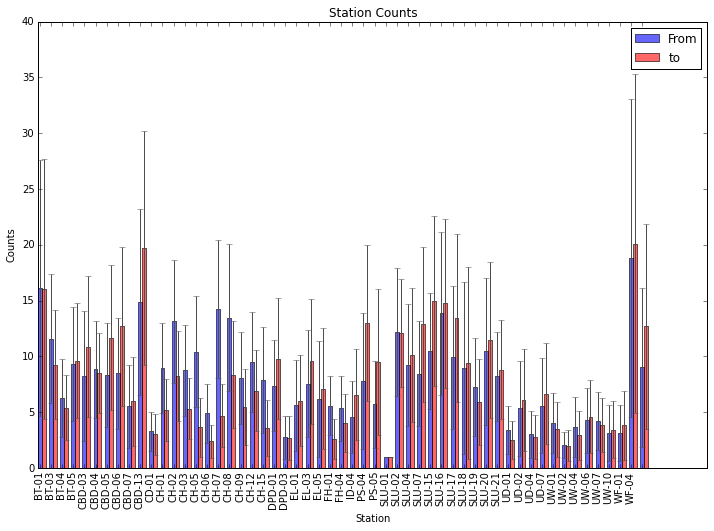

In [25]:
"""
Plotting two variables as a bar chart with error bars
"""
import numpy as np
import matplotlib.pyplot as plt


n_groups = len(df_day_counts.index)
index = np.arange(n_groups)  # The "raw" x-axis of the bar plot
fig = plt.figure(figsize=(12, 8))  # Controls global properties of the bar plot
bar_width = 0.35  # Width of the bars
opacity = 0.6  # How transparent the bars are

#VVVV Changed to do two plots with error bars
error_config = {'ecolor': '0.3'}
rects1 = plt.bar(index, df_day_counts.from_mean, bar_width,
                 alpha=opacity,
                 color='b',
                 yerr=df_day_counts.from_std,
                 error_kw=error_config,
                 label='From')
rects2 = plt.bar(index + bar_width, df_day_counts.to_mean, bar_width,
                 alpha=opacity,
                 color='r',
                 yerr=df_day_counts.to_std,
                 error_kw=error_config,
                 label='to')
#^^^^ Changed to do two plots with error bars

plt.xticks(index + bar_width / 2, df_counts.index)
_, labels = plt.xticks()  # Get the new labels of the plot
plt.setp(labels, rotation=90)  # Rotate labels to make them readable
plt.legend()

plt.xlabel('Station')
plt.ylabel('Counts')
plt.title('Station Counts')
plt.show()

## In-class exercise
- Using the pronto data, explore comparisons & trends in # rides by time of day, day of week, station, month, membership, gender
- What index works best to do these comparisons?

Work in teams of three
- One person in the team will give a 2 minute summary at end of class